# Predicting Stock Prices with Pandas & Scikit-Learn
* Check historical stock prices - using Pandas web-data reader & Yahoo Finance
* Check the data with EDA - using a correlation heatmap, matplotlib
* Perform prediction analysis - using Linear Analysis & KNN

## Load Data
* Pandas web data reader - extends Pandas to work with Yahoo Finance, Google Finance, Enigma, etc.
* Extract Apple Stock Prices

In [2]:
import pandas as pd
import datetime

!pip install pandas_datareader

import pandas_datareader.data as web
from pandas import Series, DataFrame

start = datetime.datetime(2010, 1, 1)

end = datetime.datetime(2017, 1, 11)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

    100% |████████████████████████████████| 112kB 2.4MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-06,118.160004,116.470001,116.779999,117.910004,31751900.0,113.402542
2017-01-09,119.430000,117.940002,117.949997,118.989998,33561900.0,114.441246
2017-01-10,119.379997,118.300003,118.769997,119.110001,24462100.0,114.556656
2017-01-11,119.930000,118.599998,118.739998,119.750000,27588600.0,115.172195
2017-01-12,119.300003,118.209999,118.900002,119.250000,27086200.0,114.691307


## Analyze stocks using 2 measurements - Rolling Mean & Return Rate
* Rolling Mean - also known as Moving Average (MA) - keeps a constantly updated Average Price
* MA acts as Resistance - meaning it is less likely to deviate outside downtrend and uptrend

### Establish the Rolling Mean
* calculate MA over last 100 days (100 windows) of closing price

In [3]:
close_px = df['Adj Close']

mavg = close_px.rolling(window=100).mean()

In [4]:
mavg.tail(10)

Date
2016-12-29    107.331329
2016-12-30    107.404094
2017-01-03    107.487785
2017-01-04    107.570894
2017-01-05    107.657286
2017-01-06    107.743742
2017-01-09    107.841542
2017-01-10    107.942027
2017-01-11    108.050006
2017-01-12    108.150498
Name: Adj Close, dtype: float64

### Plot MA using Matplotlib - Overlay MA with Stocks Price Chart

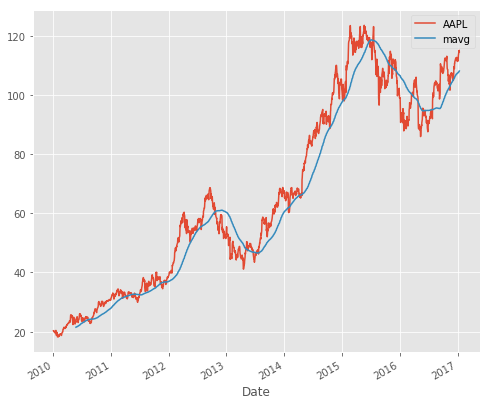

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

import matplotlib as mlp
mlp.rc('figure', figsize=(8,7))
mlp.__version__

style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')

plt.legend()

### Return Rate/Deviation - for determining Risk & Return
* expected Return - measures mean (or expected value), of the probability distribution of returns
* expected return of a portfolio - found by multiplying asset weights by expected returns, and adding the values of each investment

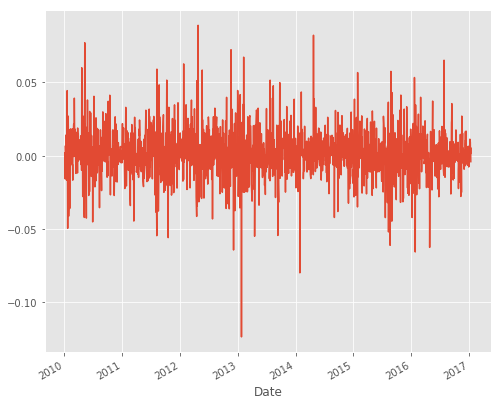

In [7]:
rets = close_px / close_px.shift(1) - 1

rets.plot(label = 'return')

* notice the 2013 drop

## Analyzing Competitors' Stocks
* compare Apple, GE, Google, IBM, and Microsoft

In [8]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'], 'yahoo', start=start, end=end)['Adj Close']

In [9]:
dfcomp.tail()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2017-01-06,113.402542,28.048019,806.150024,152.527573,59.942703
2017-01-09,114.441246,27.914923,806.650024,150.836121,59.751923
2017-01-10,114.556656,27.835064,804.789978,148.919739,59.732849
2017-01-11,115.172195,27.923794,807.909973,150.926086,60.276566
2017-01-12,114.691307,27.852808,806.359985,151.106049,59.723312


## Correlation Analysis
* does 1 competitor influence the others?
* check the percentage change, and correlation function in pandas

In [10]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()

### Plot Apple & GE - using Scatterplot, to view return distributions

Text(0,0.5,'Returns GE')

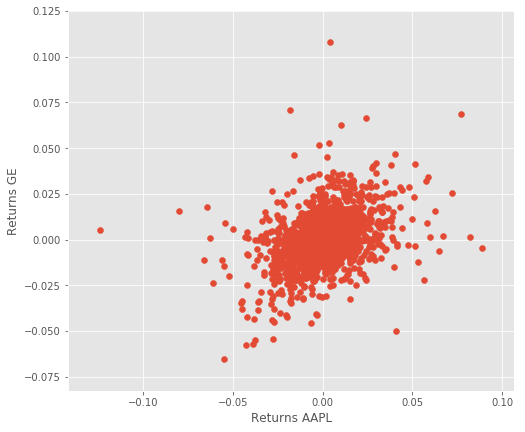

In [11]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

* slight appearance of a positive correlation between increasing Apple and increasing GE

### Plot a Scatter Matrix - view possible correlations between Competitors
* at the diagonal - run the Kernel Density Estimate, KDE
    * KDE, helps in generating estimates of the overall distribution

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


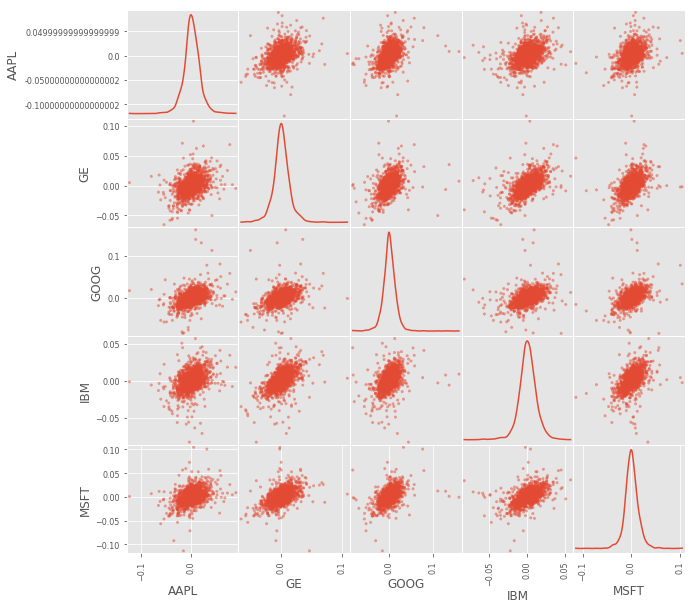

In [12]:
pd.scatter_matrix(retscomp, diagonal='kde', figsize=(10,10));

### Use Heatmaps - view the correlation ranges among Competitors
* lighter the color, stronger the correlation

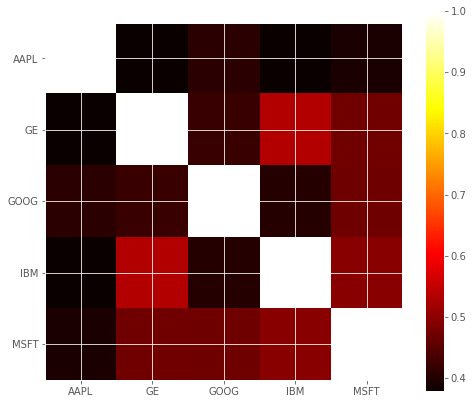

In [13]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

* though there are correlations, it may not be indicative of causality

## Analyze each stock's Risks & Returns
* retrieve the Return Rate - average rate of returns
* retrieve the Risk - standard deviation of returns

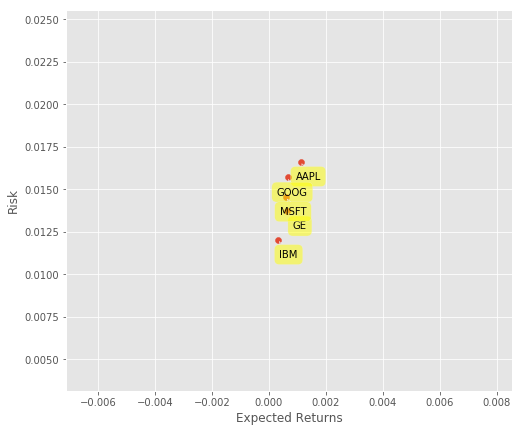

In [15]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected Returns')
plt.ylabel('Risk')

for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(label, xy = (x, y), xytext = (20, -20),
                textcoords = 'offset points', ha = 'right',
                va = 'bottom', bbox = dict(boxstyle = 'round, pad =0.5', fc = 'yellow', alpha=0.5),
                arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3, rad=0'))

* Could establish a threshold for minimizing risks and maximizing returns
* A line could be drawn for risk-return tolerance

# Predict Stock Price
* using Simple Linear Analysis, Quadratic Discriminant Analysis (QDA), and K Nearest Neighbor (KNN)

## Feature Engineering
* High Low Percentage - HL_PCT
* Percentage Change - PCT_change

In [18]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [19]:
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2010-01-04,20.307869,123432400.0,0.990606,0.271752
2010-01-05,20.342979,150476200.0,1.091520,-0.102519
2010-01-06,20.019398,138040000.0,2.123523,-1.590633
2010-01-07,19.982389,119282800.0,1.400893,-0.552538
2010-01-08,20.115240,111902700.0,1.386924,0.798864


### Preprocessing & CV
* Drop missing values
* Separate Target Label - AdjClose
* Scale X - for linear distribution consistency

In [27]:
import math
import numpy as np
from sklearn import preprocessing

dfreg.fillna(value = -99999, inplace = True)

# step 2 above - requires separating the last 1 day (1 %) of data for forecasting

forecast_out = int(math.ceil(0.01 * len(dfreg)))

forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)

X = np.array(dfreg.drop(['label'], 1))
X = preprocessing.scale(X)

* Find Data Series for Late X & Early X (training) - for model generation/evaluation
* Separate label, identifying it as y
* Split data into Training & Test sets

In [28]:
from sklearn import preprocessing, cross_validation, svm

X_lately = X[-forecast_out:]
X = X[:-forecast_out]

y = np.array(dfreg['label'])
y = y[:-forecast_out]

print(dfreg.shape)
print('Dimensions of X', X.shape)
print('Dimensions of y', y.shape)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2)

(1770, 5)
Dimensions of X (1752, 4)
Dimensions of y (1752,)


## Generate Model

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

### Simple Linear Analysis
* Linear relationship between 2+ variables
* drawing this relationship between 2 variables, produces a straight line

#### Quadratic Discriminant Analysis
* similar, but model allows polynomials, and produces curves

In [30]:
# linear, regression

clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# quadratic, regression 2

clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# quadratic, regression 3

clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

### K Nearest Neighbor - KNN
* predicts data point values, based on feature similarity
* similarity determined by minimum distance between points (Euclidean distance)

In [31]:
clfknn = KNeighborsRegressor(n_neighbors = 2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

## Evaluate Models
* use the score method
    * which finds the mean accuracy of self.predict(X) with y_test

In [33]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test, y_test)
confidencepoly3 = clfpoly3.score(X_test, y_test)
confidenceknn = clfknn.score(X_test, y_test)

print('Lin Reg confidence:', confidencereg)
print('Quad Reg 2 confidence:', confidencepoly2)
print('Quad Reg 3 confidence:', confidencepoly3)
print('KNN Reg confidence:', confidenceknn)

Lin Reg confidence: 0.978801338462954
Quad Reg 2 confidence: 0.9740545903155944
Quad Reg 3 confidence: -0.16508872009200615
KNN Reg confidence: 0.9584329619631302


* some decent confidence scores - however, all stocks do not have the same trajectories

### View some forecasted stock prices

In [35]:
forecast_set = clfreg.predict(X_lately)

dfreg['Forecast'] = np.nan

In [37]:
print(forecast_set, confidencereg, forecast_out)

[111.33649689 112.58860608 112.63397083 112.59537737 111.96856707
 112.39525549 113.19177546 112.97708407 112.49488689 111.90708609
 112.10676172 111.7503901  112.39577158 113.70520984 114.57952278
 114.69589553 115.32146713 114.78070524] 0.978801338462954 18


## Plot Predictions

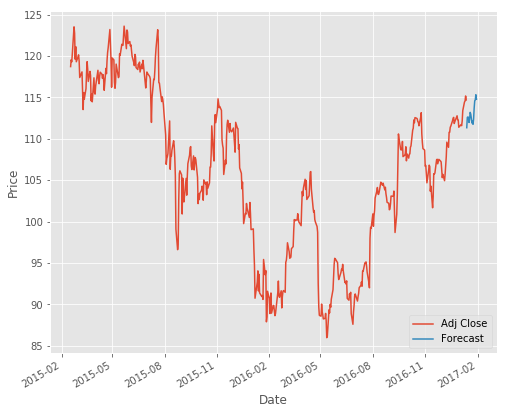

In [38]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()